### **Import Libraries**


In [16]:
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pickle
# Import MAPIE to calculate prediction intervals
from mapie.regression import MapieRegressor

# To calculate coverage score
from mapie.metrics import regression_coverage_score
%matplotlib inline

print("Libraries imported.")


Libraries imported.


### **Load Dataset as DataFrame & Drop Null Values**

In [17]:
tv_df = pd.read_csv('Traffic_Volume.csv')
tv_df.head()
#tv_df.dropna(inplace = True)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,10/2/12 9:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,10/2/12 10:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,10/2/12 11:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,10/2/12 12:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,10/2/12 13:00,4918


### **Input & Output Features**


In [18]:
output = tv_df['traffic_volume']

features = tv_df[['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'date_time']]



# chatGPT suggestion to convert datetime into following columns
features['date_time'] = pd.to_datetime(features['date_time'])
features['hour'] = features['date_time'].dt.hour
features['dayofweek'] = features['date_time'].dt.dayofweek
features['month'] = features['date_time'].dt.month
features.drop(columns=['date_time'], inplace=True)


C:\Users\david\AppData\Local\Temp\ipykernel_56788\107942349.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  features['date_time'] = pd.to_datetime(features['date_time'])
C:\Users\david\AppData\Local\Temp\ipykernel_56788\107942349.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['date_time'] = pd.to_datetime(features['date_time'])


### **One-Hot Encoding Categorical Variables**


In [19]:
cat_var = ['holiday', 'weather_main']
features_encoded = pd.get_dummies(features, columns=cat_var)
features_encoded.head()

,temp,rain_1h,snow_1h,clouds_all,hour,dayofweek,month,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,...,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm
0,288.28,0.0,0.0,40,9,1,10,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,289.36,0.0,0.0,75,10,1,10,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,289.58,0.0,0.0,90,11,1,10,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,290.13,0.0,0.0,90,12,1,10,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,291.14,0.0,0.0,75,13,1,10,False,False,False,...,True,False,False,False,False,False,False,False,False,False


### **Data Partitioning**


In [20]:
train_X, test_X, train_y, test_y = train_test_split(features_encoded, output, test_size=0.2, random_state=1)

### **Create Model Instance & Fit To Training Data**


In [21]:
# code from tutorial, parameter values from ChatGPT
XGb_reg = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, random_state=1)
# fit model
XGb_reg.fit(train_X, train_y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

### **Make Predictions**


In [22]:
# make predictions
pred_y = XGb_reg.predict(test_X)

### **Evaluate Model Performance**


In [23]:
# RMS error suggested by chatGPT
r2=r2_score(test_y, pred_y)
rmse = np.sqrt(mean_squared_error(test_y, pred_y))
# use this instead?:RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, pred_y)

### **Feature Importance Plot**


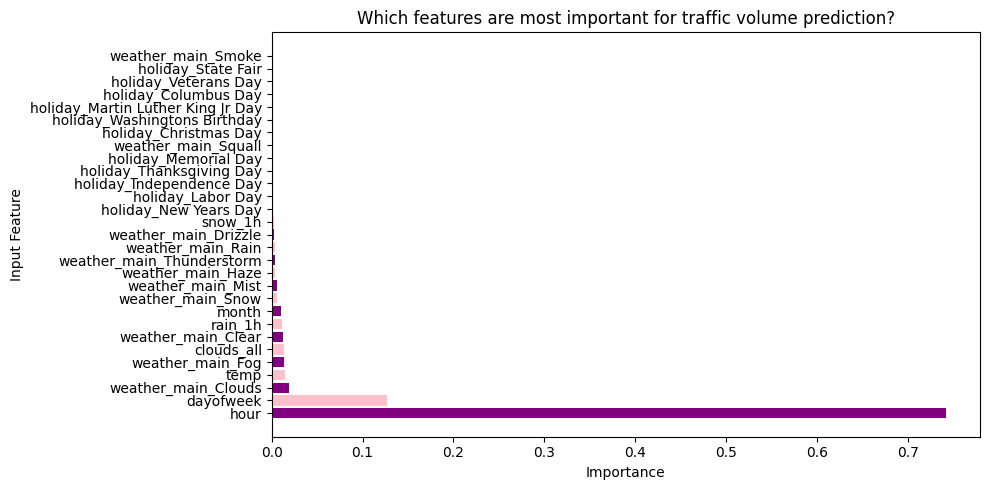

In [24]:
# Storing importance values from the trained model
importance = XGb_reg.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize = (10, 5))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['purple', 'pink'])

plt.xlabel("Importance")
plt.ylabel("Input Feature")
plt.title('Which features are most important for traffic volume prediction?') 
plt.tight_layout()
plt.savefig("feature_imp_XGB.svg");

### **Histogram of Residuals/Errors**


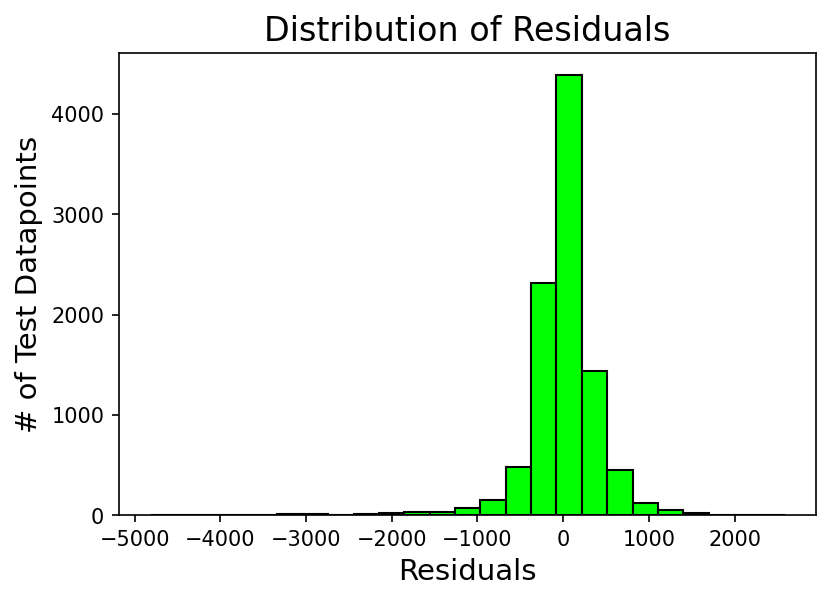

In [25]:
# Calculate the residuals by subtracting the predicted values from the actual test values
all_residuals = test_y - pred_y

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'lime', edgecolor = 'black')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("residuals_XGB.png")

### **Scatterplot of Predicted vs Actual Values**


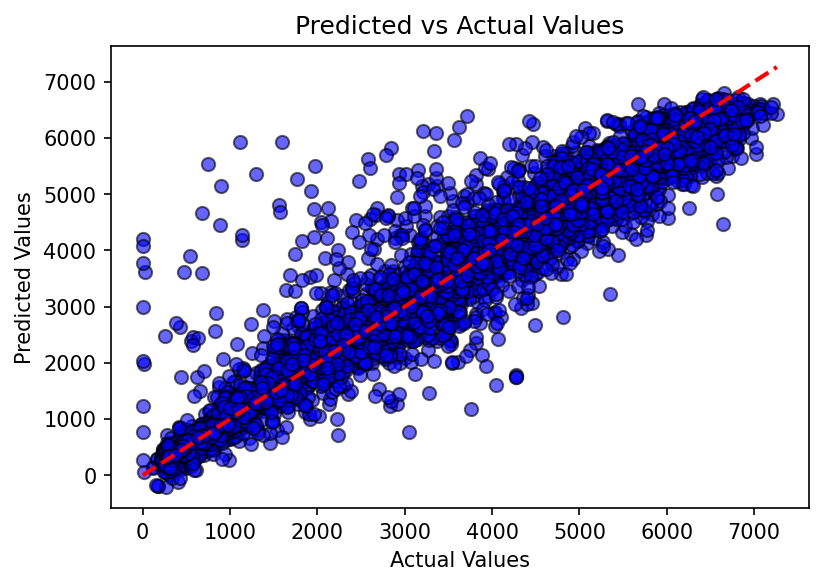

In [26]:
# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(test_y, pred_y, color = 'blue', alpha = 0.6, edgecolor = 'black', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("scatter_XGB.png")

### **Prediction Intervals Using MAPIE**


In [28]:
# Define MAPIE regressor
mapie = MapieRegressor(estimator = XGb_reg, # Prediction model to use
                       n_jobs = -1,
                       cv='split',          # suggested by chatGPT to avoid memory issues I was having
                       random_state = 42)

# Fit mapie regressor on training data
mapie.fit(train_X, train_y)

alpha = 0.1 # For 90% confidence level

# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie.predict(test_X, alpha = alpha)

# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

### **Coverage Calculation**



In [29]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")



Coverage: 89.50%


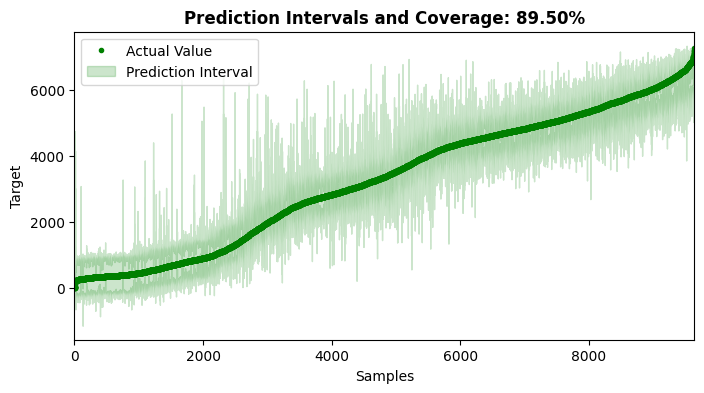

In [30]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'go', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="green", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);
plt.savefig("coverage_XGB.png")

### **Save Model**


In [31]:

# save model without MAPIE
reg_pickle_NM = open('traffic_volume_XGB_noMAPIE.pickle', 'wb')
pickle.dump(XGb_reg, reg_pickle_NM)
reg_pickle_NM.close()


# save model with MAPIE
reg_pickle = open('traffic_volume.pickle', 'wb') 

# Write RF model to the file
pickle.dump(mapie, reg_pickle) 

# Close the file
reg_pickle.close()